このアプリはsupabaseを使用した画像投稿アプリです。
以下のように、画像を選択、コメントを入力して「アップロード」を押すことで、画像を投稿することができます。
また、他の人が投稿した画像を見ることもできます。

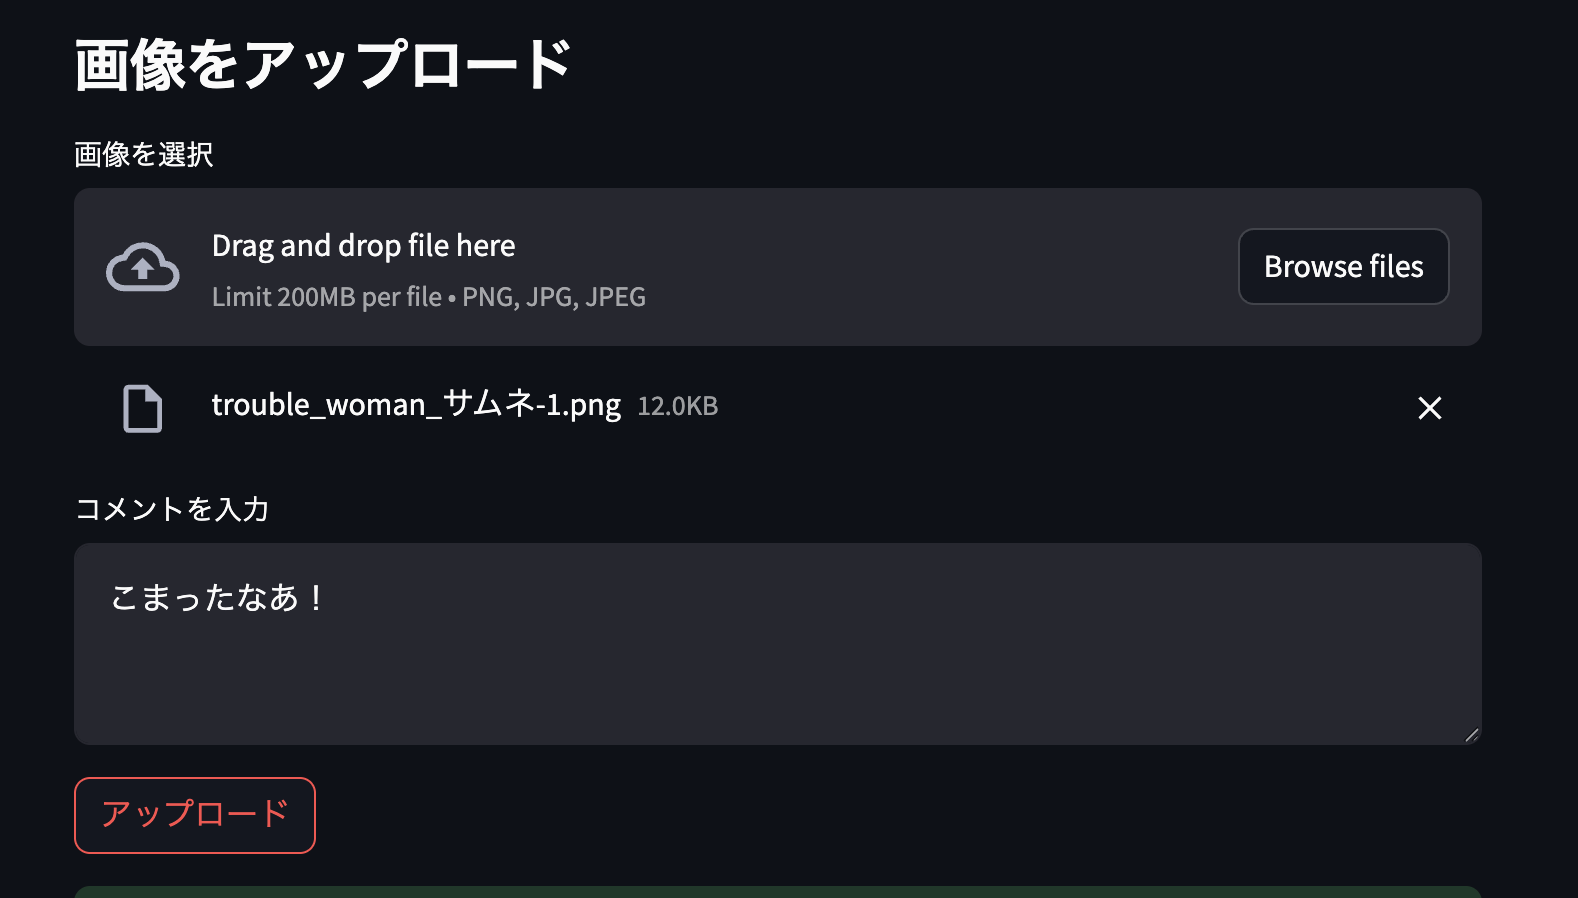
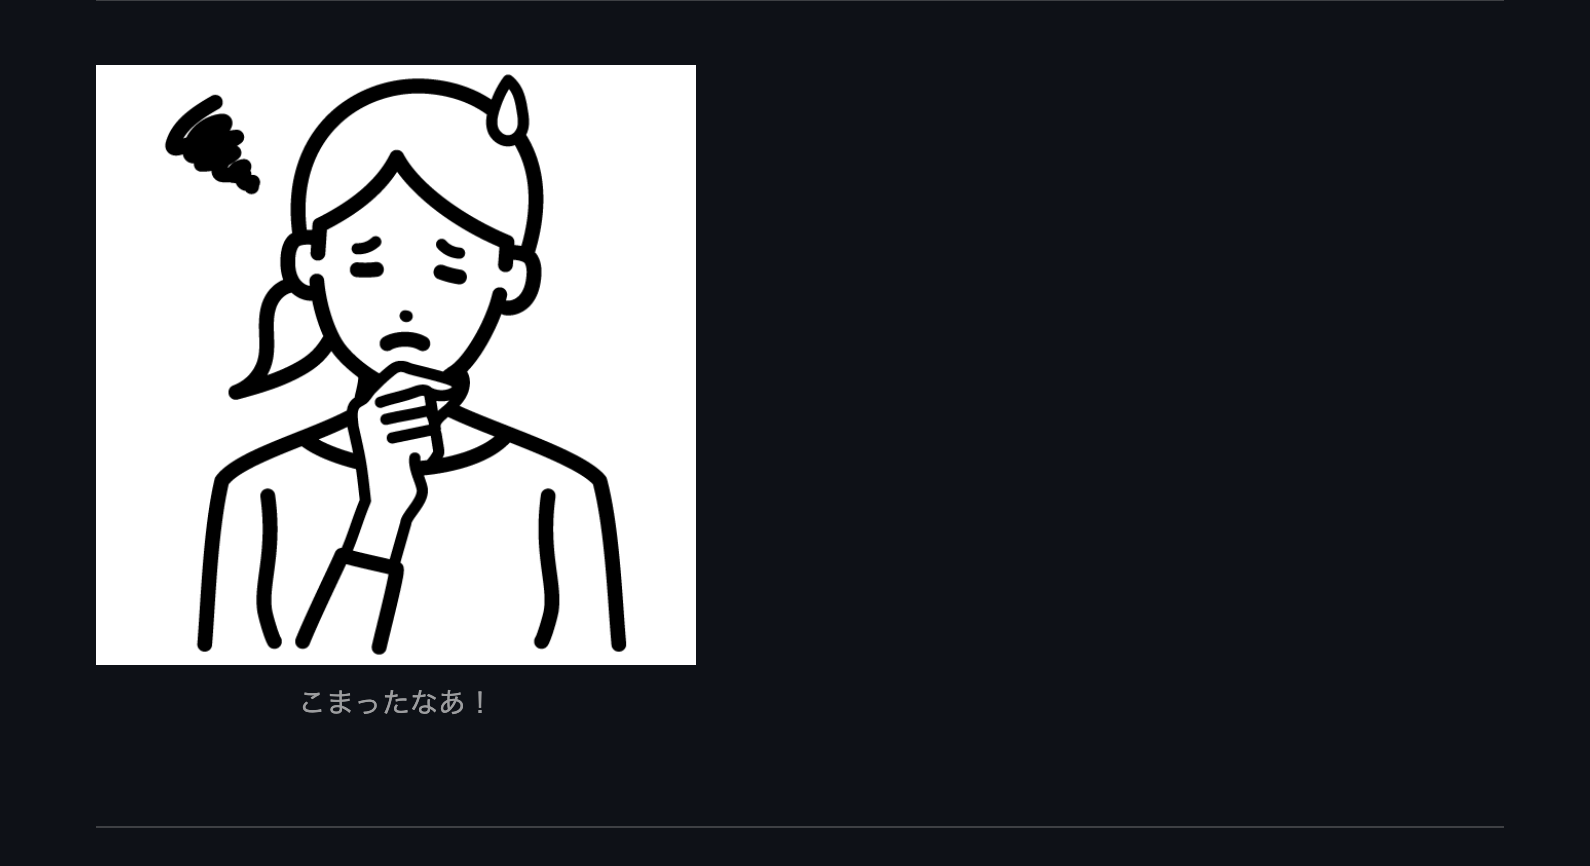

### supabaseについて

supabaseはBackend-as-a-Service(BaaS)と呼ばれ、アプリケーションのバックエンドを簡単に構築できるように設計されたサービスで、データベース機能やファイルストレージ機能、認証/アクセス制御サービスなどバックエンドの構築を簡単に行える機能を持っています。https://supabase.com/


今回は、supabaseのデータベース機能とファイルストレージ機能、そしてstreamlitを活用して簡単な画像投稿アプリを作ります。

以下の流れでsupabaseを扱います。
- １．supabaseのユーザー登録
- ２．新しいプロジェクトを作成しDBを作成　https://qiita.com/pikimaru/items/5e51d36250c288b8b6dc
- ３．画像保存場所を作成　※記事の「バケットを作成しよう」の部分　https://qiita.com/kaho_eng/items/84df0ccfdc0ab5b8eb83
- ４．Project URLとAPI Key(servece_role)の取得（取得方法を調べてみてください）

「２．新しいプロジェクトを作成しDBを作成」については、以下のようなDBを作成してください。また、RLS(Row Level Security)をdisabledに設定してください。（本来はRLSにより書き込みができるユーザーを制御することができますが今回は省略）

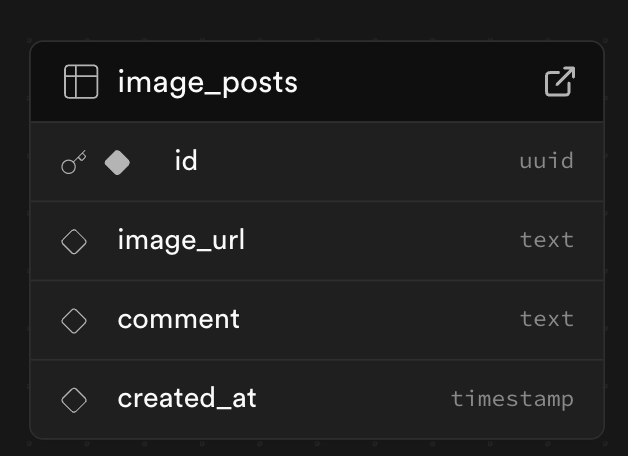


「３．画像保存場所を作成」については、バケット名を「image-storage」とし、Public bucketとして作成してください。

ここまでできたら、.envファイルを作成して環境変数を記載します。

In [ ]:
SUPABASE_URL="project url"
SUPABASE_KEY="API key(servece_role)"

ここからコードを書いていきます。まず初めに、使用するライブラリをインポート。

In [ ]:
import streamlit as st
from supabase import create_client, Client
import uuid
from datetime import datetime
import os
from dotenv import load_dotenv

.envに記載した内容を読み込めるようにします。

In [ ]:
load_dotenv()

Python で Supabase に接続するためのクライアントを作成

In [ ]:
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

（補足）これにより、例えば以下のような操作ができるようになります。

- snacksテーブルの全データ（すべての列）を取得しdataに格納

In [ ]:
data = supabase.table("snacks").select("*").execute()

- snacksテーブルに、1件のデータを新しく追加（name カラム：ポテチ、price カラム：150）

In [ ]:
supabase.table("snacks").insert({"name": "ポテチ", "price": 150}).execute()

タイトル、小見出し設定、画像アップロードするためのファイル選択UIとコメント入力場所の作成

In [ ]:
st.title("画像投稿アプリ")
# --- 画像＆コメント投稿 ---
st.subheader("画像をアップロード")

uploaded_file = st.file_uploader("画像を選択", type=["png", "jpg", "jpeg"])
comment = st.text_area("コメントを入力")

- ユーザーがアップロードボタンをクリックしたことを検知し、
- ユーザーが画像ファイルとコメントを両方入力していることを確認し、
- アップロードされた画像ファイルに一意の名前をつけ、
- 画像をsupabaseのstorageにアップロードし、
- アップロードが成功したら、コメントと画像のURLをimage_postsテーブルに保存し、
- 成否に応じてメッセージを表示する

In [ ]:
if st.button("アップロード"):
    if uploaded_file and comment:
        image_id = str(uuid.uuid4())
        file_path = f"{image_id}.png"

        image_data = uploaded_file.read()
        # 画像を Supabase Storage にアップロード
        res = supabase.storage.from_("image-storage").upload(file_path, image_data)
        if isinstance(res, dict) and "error" in res:
            st.error("画像のアップロードに失敗しました: " + str(res["error"]))
        else:
            image_url = f"{SUPABASE_URL}/storage/v1/object/public/image-storage/{file_path}"

            # DBにデータを保存（ユーザーIDなし）
            supabase.table("image_posts").insert({
                "id": str(uuid.uuid4()),
                "image_url": image_url,
                "comment": comment,
                "created_at": datetime.utcnow().isoformat()
            }).execute()

            st.success("画像をアップロードしました！")

投稿を表示する！

In [ ]:
# --- 投稿一覧の表示 ---
st.subheader("投稿一覧")
posts = supabase.table("image_posts").select("*").execute()

if posts.data:
    for post in posts.data:
        st.image(post["image_url"], caption=post["comment"], width=300)
        st.write("---")
else:
    st.write("まだ投稿がありません。")

以上で完成です！

（おまけ）コード全体

In [ ]:
import streamlit as st
from supabase import create_client, Client
import uuid
from datetime import datetime
import os
from dotenv import load_dotenv

load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

st.title("画像投稿アプリ")

# --- 画像＆コメント投稿 ---
st.subheader("画像をアップロード")

uploaded_file = st.file_uploader("画像を選択", type=["png", "jpg", "jpeg"])
comment = st.text_area("コメントを入力")

if st.button("アップロード"):
    if uploaded_file and comment:
        image_id = str(uuid.uuid4())
        file_path = f"{image_id}.png"

        image_data = uploaded_file.read()
        # 画像を Supabase Storage にアップロード
        res = supabase.storage.from_("image-storage").upload(file_path, image_data)
        if isinstance(res, dict) and "error" in res:
            st.error("画像のアップロードに失敗しました: " + str(res["error"]))
        else:
            image_url = f"{SUPABASE_URL}/storage/v1/object/public/image-storage/{file_path}"

            # DBにデータを保存（ユーザーIDなし）
            supabase.table("image_posts").insert({
                "id": str(uuid.uuid4()),
                "image_url": image_url,
                "comment": comment,
                "created_at": datetime.utcnow().isoformat()
            }).execute()

            st.success("画像をアップロードしました！")

# --- 投稿一覧の表示 ---
st.subheader("投稿一覧")
posts = supabase.table("image_posts").select("*").execute()

if posts.data:
    for post in posts.data:
        st.image(post["image_url"], caption=post["comment"], width=300)
        st.write("---")
else:
    st.write("まだ投稿がありません。")
